In [1]:
import pygmt
import pickle
import imageio
import numpy as np
import xarray as xr

from shapely.ops import cascaded_union, polygonize
import shapely.geometry as geometry
from scipy.spatial import Delaunay
import numpy as np
import math

from descartes import PolygonPatch

import cartopy.crs as ccrs
from shapely.geometry import Point, Polygon

import matplotlib
import matplotlib.pyplot as plt

label_size = 7
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
matplotlib.rc('font', size=6)

%matplotlib inline

# River characteristics

> This notebook requires the dataset produced in notebook `6-extractBasinRivers`

In [2]:
step = 18

# Open netcdf data file for a specific time step
out_path = 'export/'
dataset = xr.open_dataset(out_path+'data'+str(step)+'.nc')

Now let's find the catchment ID corresponding to a specific coordinate:

In [3]:
nearest_point = dataset.sel(x=3.6e6, y=2.5e6, method="nearest")

We now extract the basin coordinates:

In [4]:
basinds = dataset.where(dataset.basinID==nearest_point.basinID.values)

We will now load the data saved from our previous notebook that has the main trunks of the river network from our basin (obtained using `pyshed`).

In [5]:
with open('branchesXY.data', 'rb') as filehandle:
    # read the data as binary data stream
    branch = pickle.load(filehandle)

Let's plot the dataset on a map:

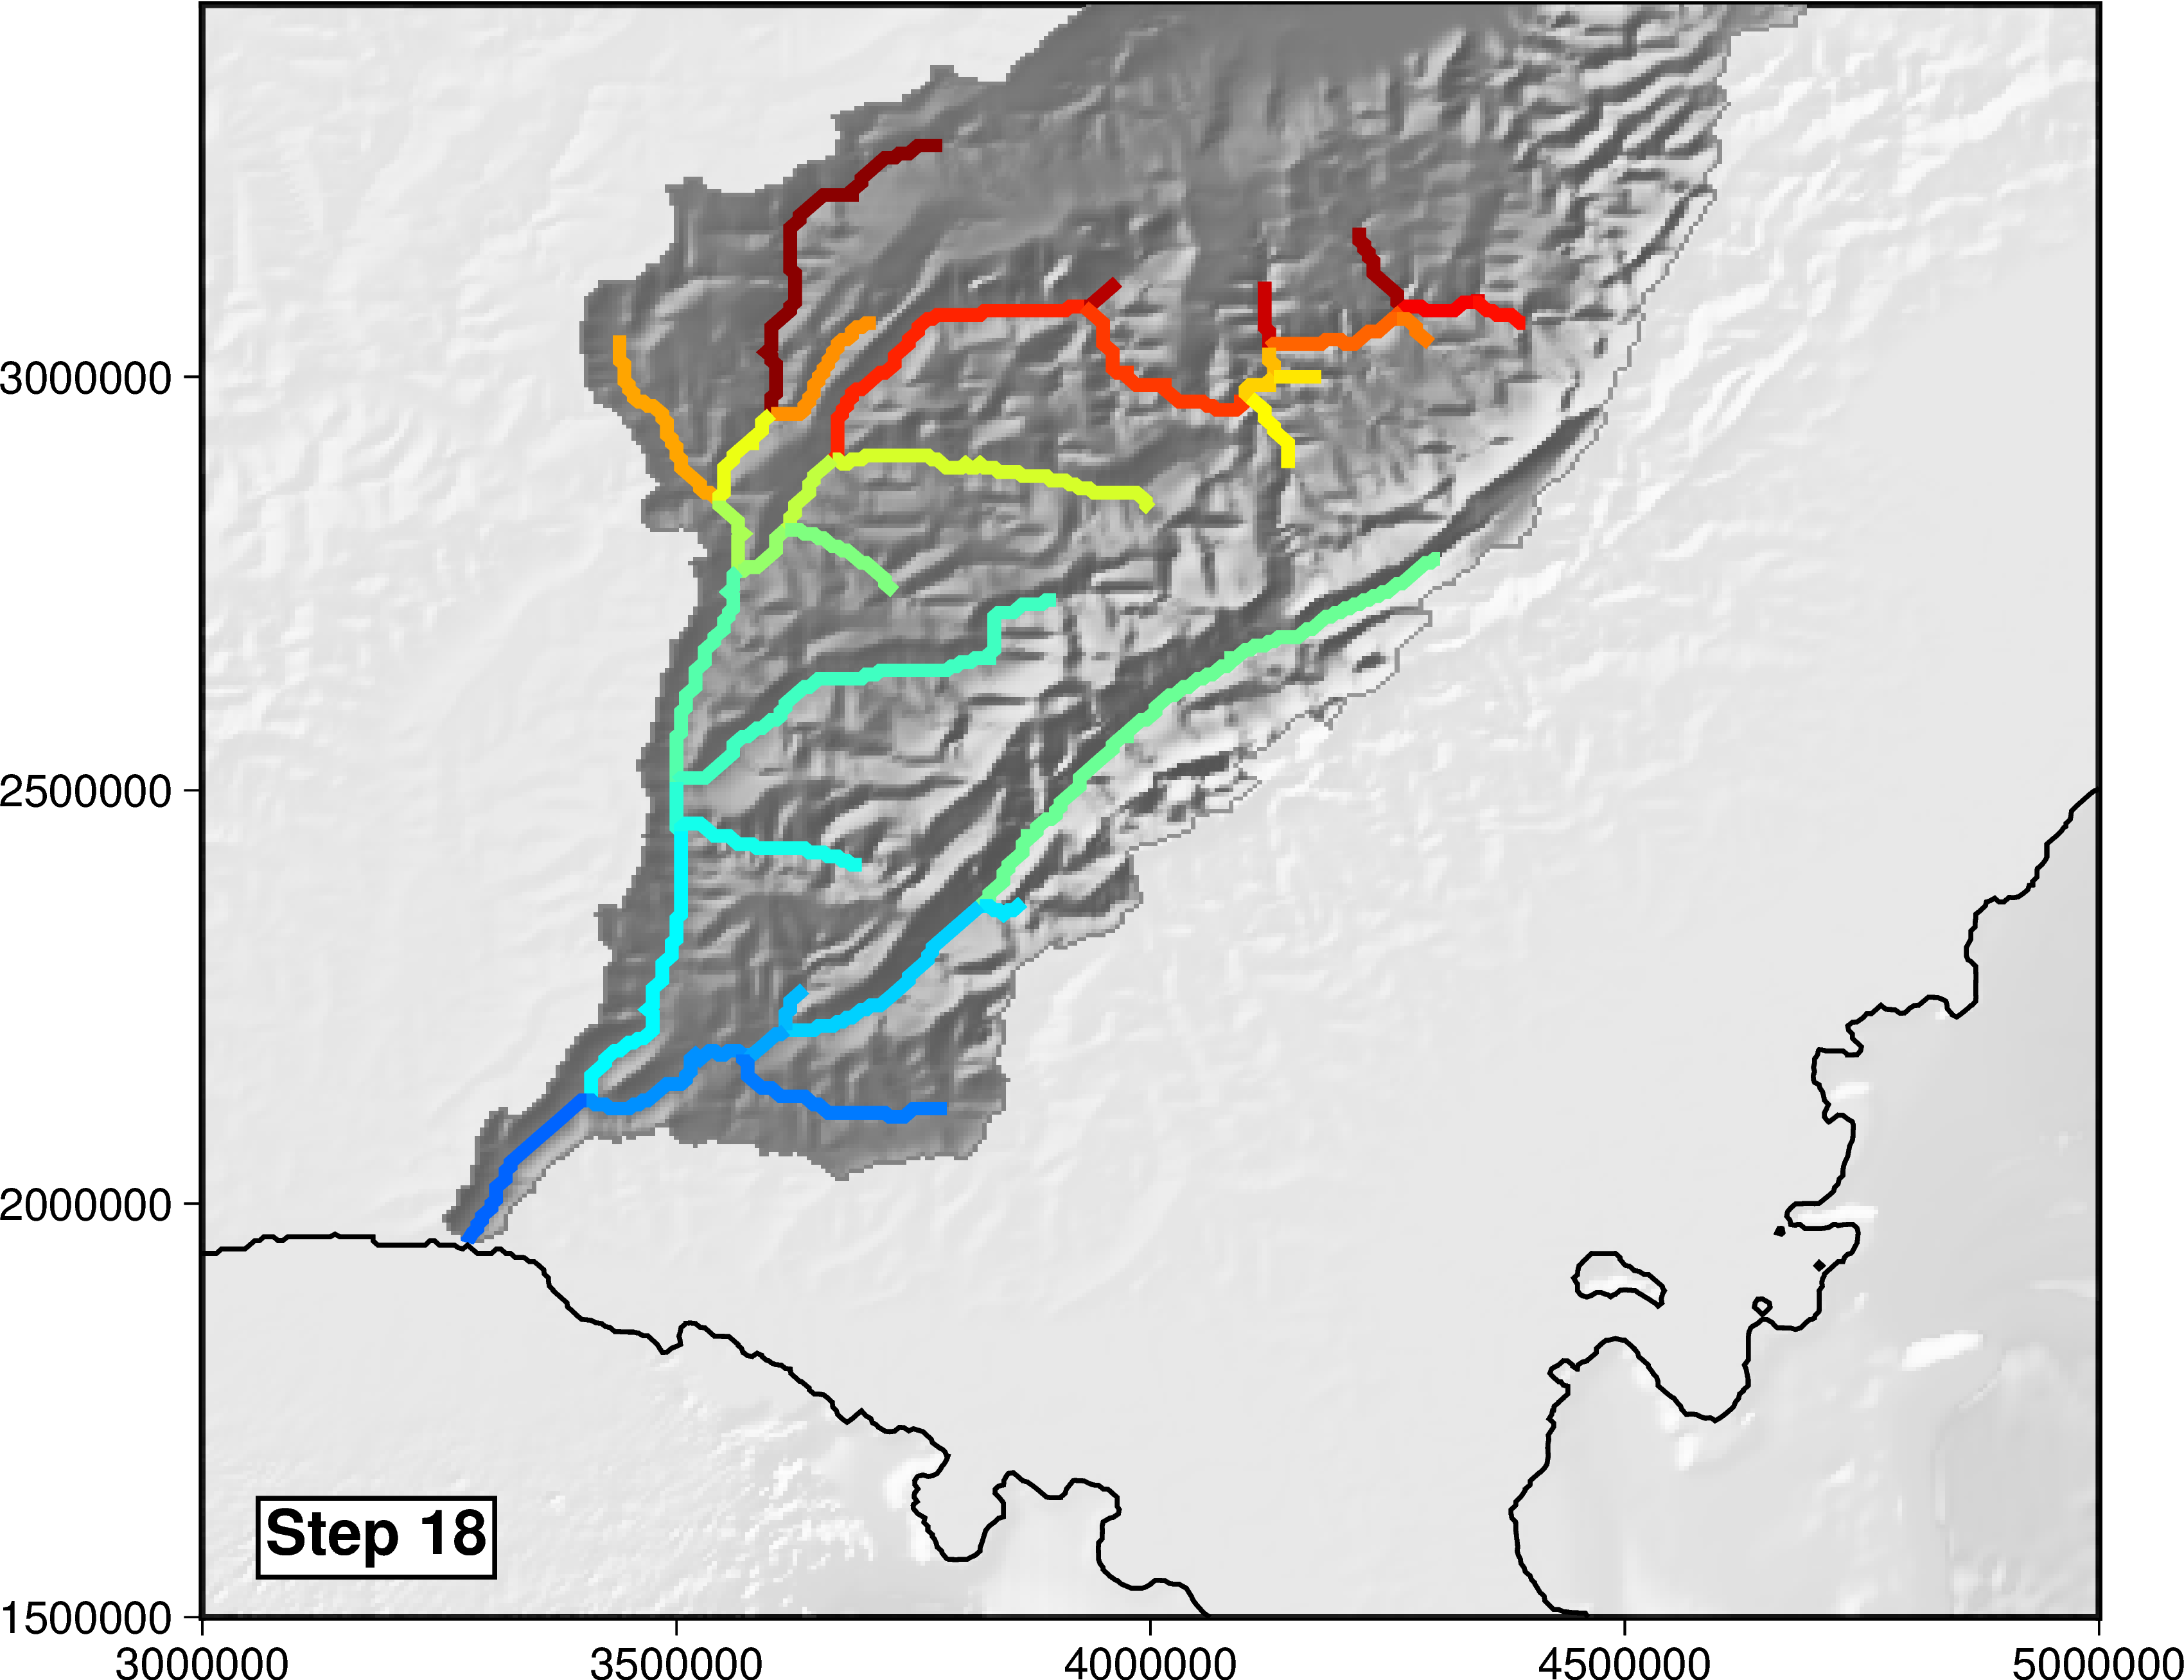

In [9]:
fig = pygmt.Figure()
region=[3.e6,5.e6,1.5e6,3.45e6]

# Plotting elevation
with pygmt.config(FONT='10p,Helvetica,black'):
    
#     pygmt.makecpt(cmap="geo", series=[-6000, 6000])
    pygmt.makecpt(cmap="gray", series=[-6000, 6000])
    
    fig.basemap(
        region=region,
        frame=['a'],
        projection="X15c/12.75c",
    )
    
    fig.grdimage(dataset.elevation, 
                 shading=True, 
                 frame=False,
                 nan_transparent=True,
                 transparency=80,
                )
    
    fig.grdimage(basinds.elevation, 
                 shading=True, 
                 frame=False,
                 nan_transparent=True,
                 transparency=0,
                 
                )
    
    pygmt.makecpt(cmap="jet", 
                  reverse=True,
                  series=[0, 46, 1], 
                  color_model="+c0-46")
    k = 0
    for brch in branch['features']:
        line = np.asarray(brch['geometry']['coordinates'])
        newline = []
        for p in range(len(line[:,0])):
            p1 = Point(line[p, 1], line[p, 0])
            newline.append([line[p, 0], line[p, 1]])
        ll = np.asarray(newline)
        if len(ll)>1:
            fig.plot(x=ll[:, 0], y=ll[:, 1], 
                     pen="3p,purple", 
                     cmap=True, zvalue=k, 
                     transparency="0")
            k += 1
        
    # Add contour
    fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')

# At time step
fig.text(text="Step "+str(step), position="BL", 
         fill='white', pen='1p', offset='0.5',
         font="14p,Helvetica-Bold,black",)

# name = 'catchment'+str(step)+'.png'
# fig.savefig(fname=name,dpi=500)

fig.show(dpi=500, width=700)

# Plotting the river profiles

Again this is done by using the second saved dataset from the previous notebook.

In [10]:
with open('profile.data', 'rb') as filehandle:
    # read the data as binary data stream
    profile = picTristankle.load(filehandle)

We now work on the dataset to find the river points part of the basin ID

In [37]:
combdf = []

for p in range(len(profile)):
    df = profile[p]

    z = np.zeros(len(df))
    ed = np.zeros(len(df))
    fa = np.zeros(len(df))
    sl = np.zeros(len(df))

    for k in range(len(df)):
        xx = df['x'][k]
        yy = df['y'][k]
        nearest_point = dataset.sel(y=yy, x=xx, method="nearest")
        z[k] = nearest_point.elevation.values
        nearest_point = dataset.sel(y=xx, x=yy, method="nearest")
        ed[k] = nearest_point.erodep.values
        fa[k] = nearest_point.fillDischarge.values
        sl[k] = nearest_point.sedimentLoad.values
    df['nelev'] = z    
    df['ed'] = ed   
    df['fa'] = fa   
    df['sedload'] = sl  
    combdf.append(df)

### Plotting using pygmt

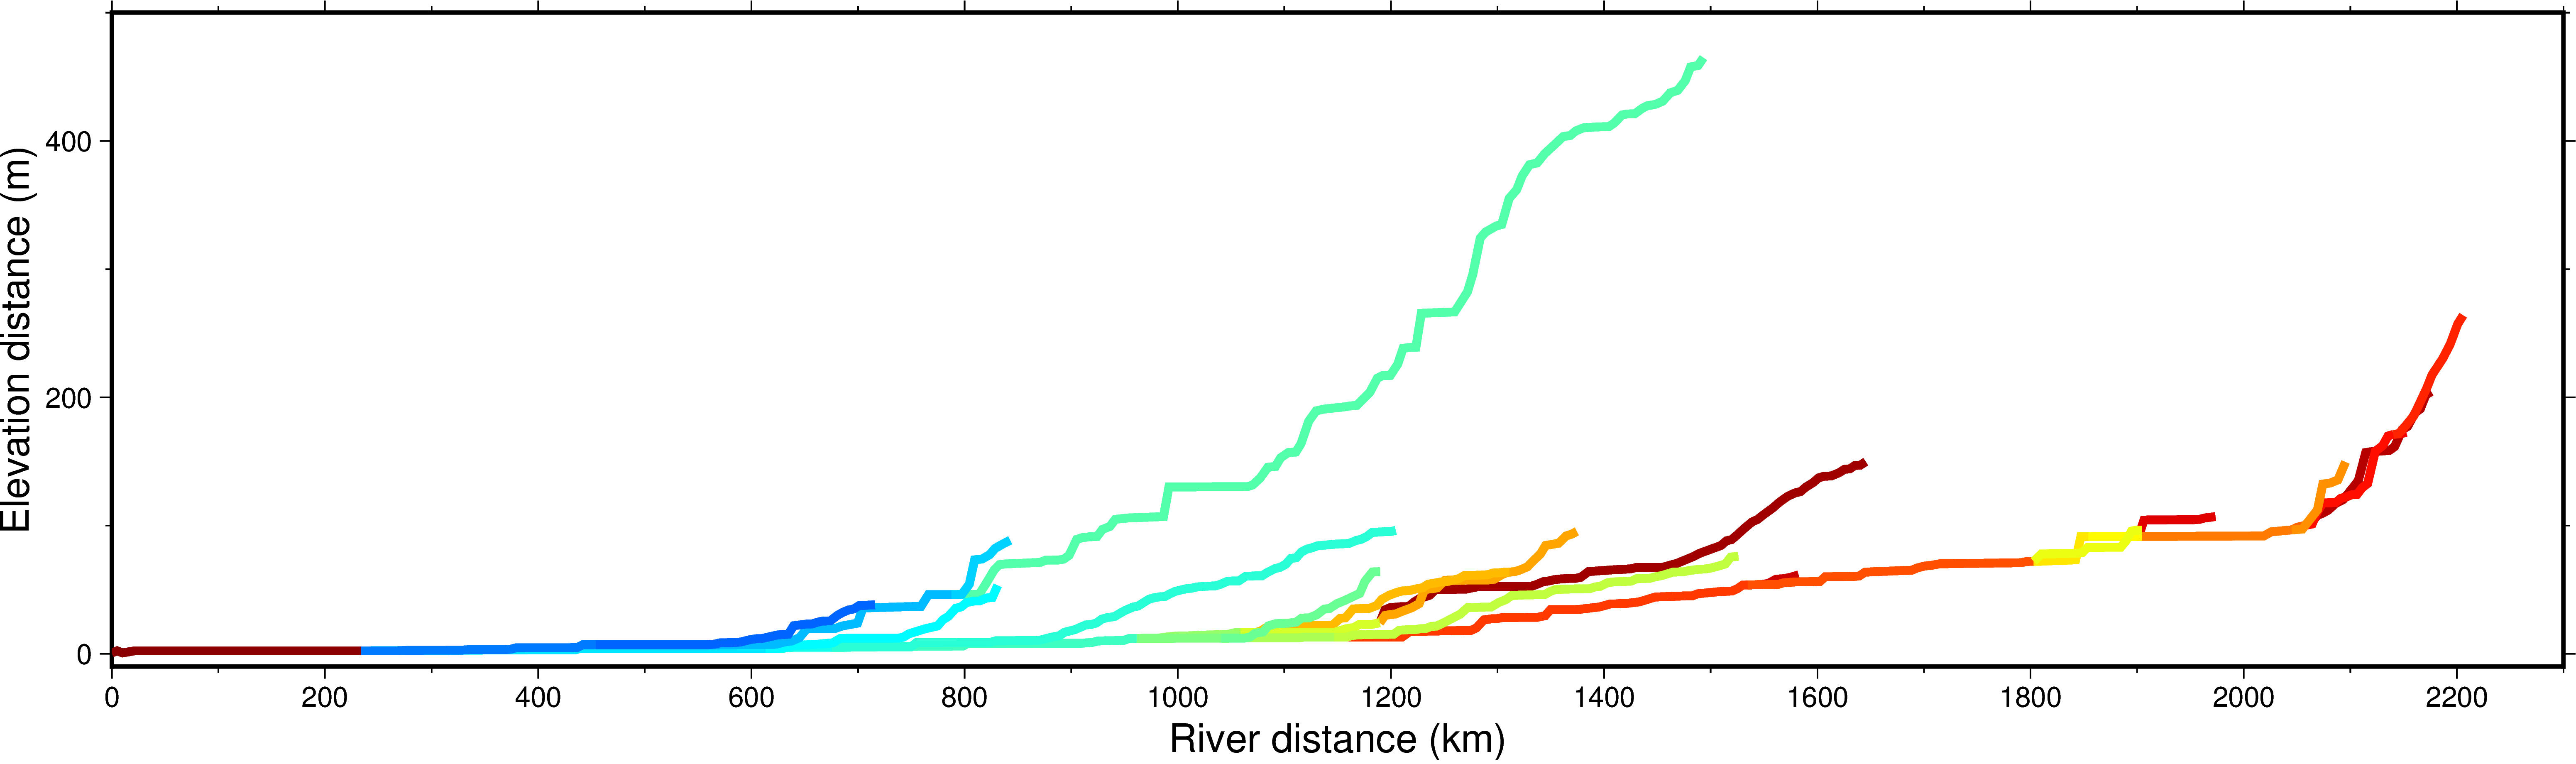

In [38]:
fig = pygmt.Figure()

with fig.subplot(nrows=1, ncols=1, figsize=("30c", "8c"), frame="lrtb"):
    with fig.set_panel(panel=0):  # sets the current panel
        
        fig.basemap(frame=["WSne", 'xaf+l"River distance (km)"', 'yaf+l"Elevation distance (m)"'], 
                    region=[0, 2300, -10, 500])
        pygmt.makecpt(cmap="jet", 
                          reverse=True,
                          series=[0, 46, 1], 
                          color_model="+c0-46")

        p = 0
        for k in range(0,len(combdf)):
            dist = np.asarray(combdf[k].dist)/1.e3
            elev = np.asarray(combdf[k].elev)
            if len(dist)>0:    
                fig.plot(x=dist, y=elev, 
                         pen="3p,purple", 
                         cmap=True, zvalue=p, 
                         transparency="0")
                p += 1  

# name = 'profile'+str(step)+'.png'
# fig.savefig(fname=name,dpi=500)
fig.show(dpi=500, width=1000)

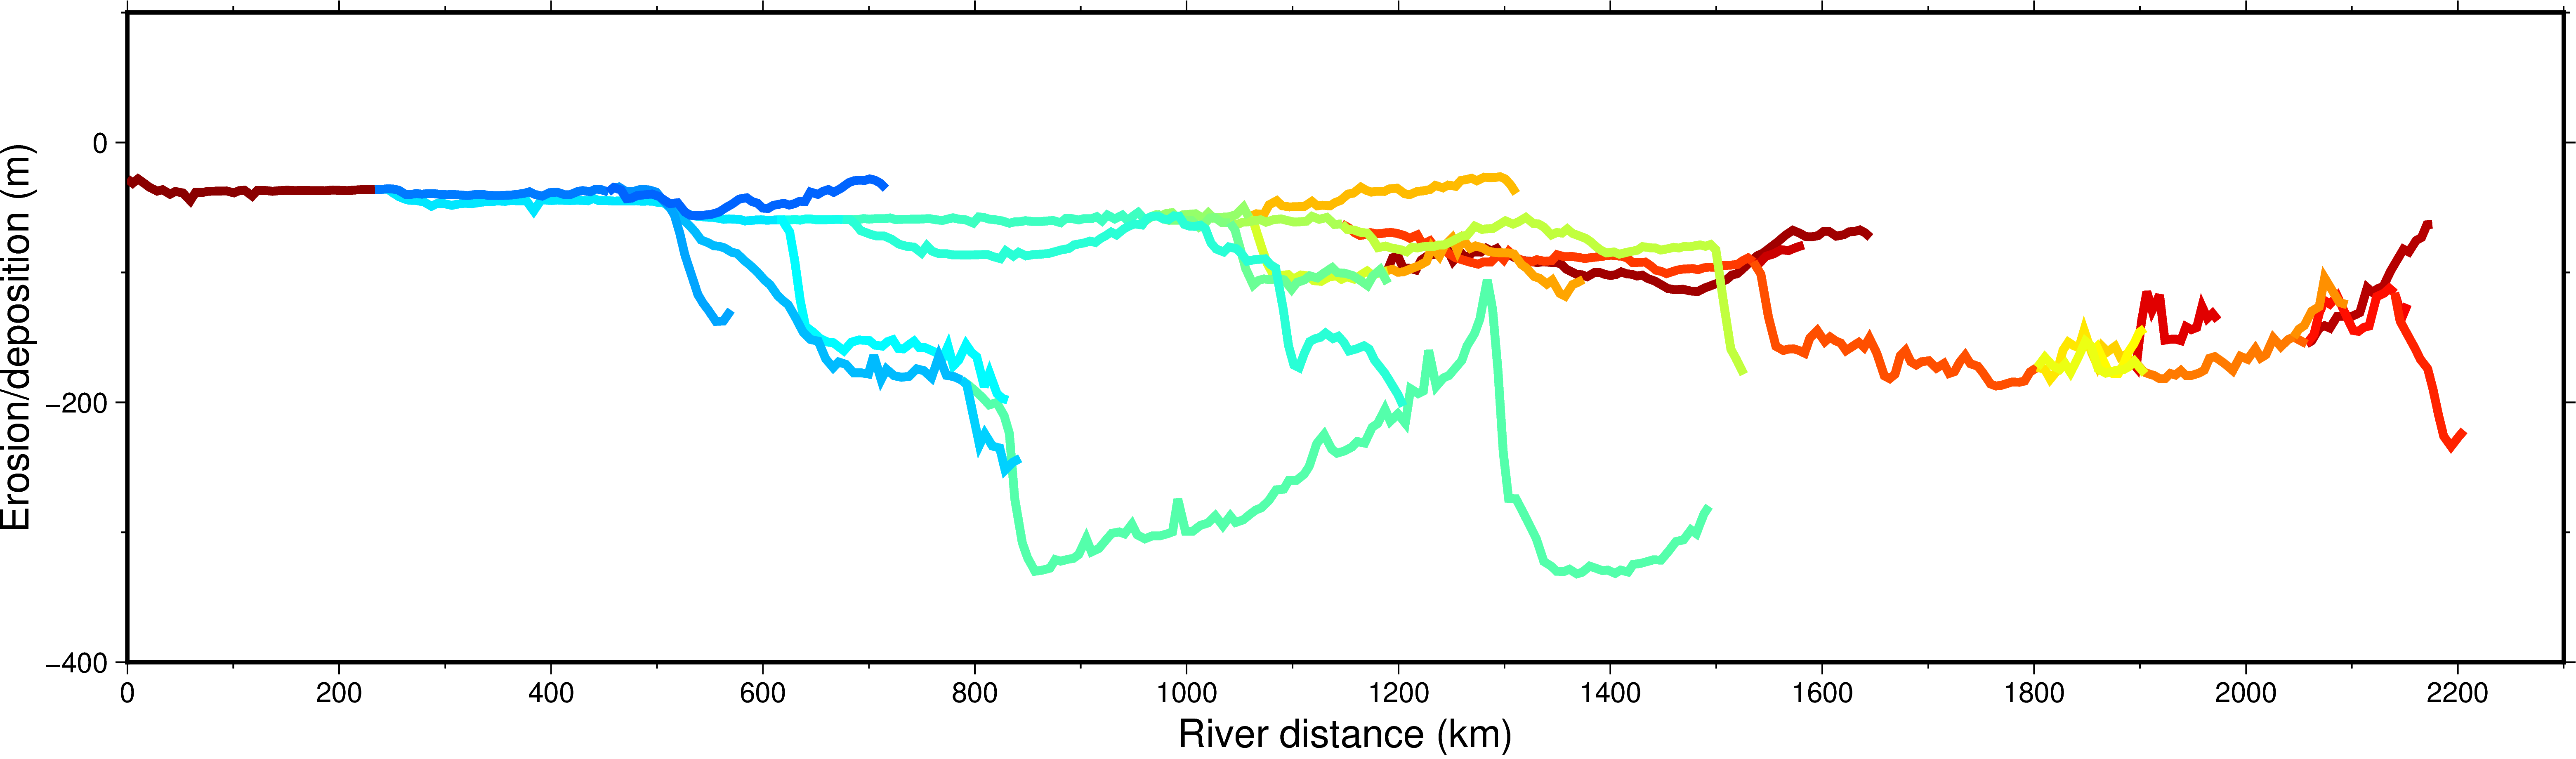

In [41]:
fig = pygmt.Figure()

with fig.subplot(nrows=1, ncols=1, figsize=("30c", "8c"), frame="lrtb"):
    with fig.set_panel(panel=0):  # sets the current panel
        
        fig.basemap(frame=["WSne", 'xaf+l"River distance (km)"', 'yaf+l"Erosion/deposition (m)"'], 
                    region=[0, 2300, -400, 100])
        pygmt.makecpt(cmap="jet", 
                          reverse=True,
                          series=[0, 46, 1], 
                          color_model="+c0-46")

        p = 0
        for k in range(0,len(combdf)):
            dist = np.asarray(combdf[k].dist)/1.e3
            elev = np.asarray(combdf[k].ed)
            if len(dist)>0:    
                fig.plot(x=dist, y=elev, 
                         pen="3p,purple", 
                         cmap=True, zvalue=p, 
                         transparency="0")
                p += 1  

# name = 'edprofile'+str(step)+'.png'
# fig.savefig(fname=name,dpi=500)
fig.show(dpi=500, width=1000)